In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import cv2
from skimage.feature import hog

C:\Users\Deepak Kumar Mondal\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
# Normalize the data to [0, 1] range
X_train = X_train / 255.0
X_test = X_test / 255.0

In [4]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

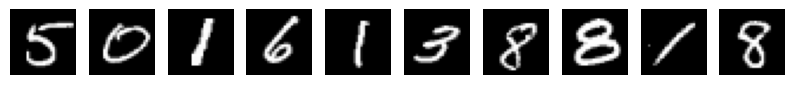

In [5]:
# Display some sample images
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.axis('off')
plt.show()

In [6]:
#Pixel intensity

In [7]:
# Flatten images to 1D arrays for pixel intensity features
X_train_flat = X_train.reshape(-1, 28 * 28)
X_val_flat = X_val.reshape(-1, 28 * 28)
X_test_flat = X_test.reshape(-1, 28 * 28)


In [8]:
# Corner Detection

In [9]:
def extract_harris_corners(image):
    gray = np.float32(image)
    dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
    corners = (dst > 0.01 * dst.max()).astype(float)
    return corners.flatten()

# Apply Harris Corner detection
harris_features_train = np.array([extract_harris_corners(img) for img in X_train])
harris_features_val = np.array([extract_harris_corners(img) for img in X_val])


In [10]:
# HOG (Histogram of Oriented Gradients)

In [11]:
def extract_hog_features(image):
    features = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    return features

# Apply HOG extraction
hog_features_train = np.array([extract_hog_features(img) for img in X_train])
hog_features_val = np.array([extract_hog_features(img) for img in X_val])


In [14]:
# Model training

In [15]:
# Combine features (HOG and Pixel Intensity)
X_train_combined = np.hstack([hog_features_train, X_train_flat])
X_val_combined = np.hstack([hog_features_val, X_val_flat])

# Apply PCA to reduce dimensionality
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_combined)
X_val_pca = pca.transform(X_val_combined)


In [16]:
# SVM Model
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_pca, y_train)

# Evaluate SVM
y_val_pred_svm = svm_model.predict(X_val_pca)
accuracy_svm = accuracy_score(y_val, y_val_pred_svm)
print(f"SVM Validation Accuracy: {accuracy_svm}")


SVM Validation Accuracy: 0.9510833333333333


In [17]:
# SGD Classifier
sgd_model = SGDClassifier(loss="hinge", max_iter=1000, tol=1e-3)
sgd_model.fit(X_train_pca, y_train)

# Evaluate SGD
y_val_pred_sgd = sgd_model.predict(X_val_pca)
accuracy_sgd = accuracy_score(y_val, y_val_pred_sgd)
print(f"SGD Validation Accuracy: {accuracy_sgd}")


SGD Validation Accuracy: 0.921


In [18]:
# Apply PCA to test set
X_test_combined = np.hstack([np.array([extract_hog_features(img) for img in X_test]), X_test_flat])
X_test_pca = pca.transform(X_test_combined)

# Evaluate on the test set with the chosen model (SVM or SGD)
y_test_pred = svm_model.predict(X_test_pca)  # or sgd_model.predict(X_test_pca) if SGD performed better
test_accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy}")
print("Confusion Matrix:")
print(conf_matrix)


Test Accuracy: 0.9567
Confusion Matrix:
[[ 968    0    3    0    0    1    3    2    2    1]
 [   1 1123    4    1    1    0    1    2    2    0]
 [   4    2  995    7    3    2    4    7    7    1]
 [   0    0   21  951    0   19    0    3   11    5]
 [   2    1    3    0  947    0    7    2    1   19]
 [   5    2    3   22    1  836    4    2   16    1]
 [  10    1    4    0    4   12  926    1    0    0]
 [   1    2   24    7    3    0    0  976    2   13]
 [   4    2    7   16    4   27    4    4  903    3]
 [   3    6    1    4   23    4    1   16    9  942]]
